In [2]:
from bs4 import BeautifulSoup as BS
from bokeh.plotting import figure, show 
import urllib.request
import pandas as pd
import numpy as np
import re as r

In [3]:
# Define URL and datframe
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()

In [4]:
# pulling data from HTML
soup = BS(resulttext, 'html.parser')

In [5]:
# prettifying the soup
print(soup.prettify)

<bound method Tag.prettify of <!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of deadly earthquakes since 1900 - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":810533305,"wgRevisionId":810533305,"wgArticleId":11673441,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from Jul

In [6]:
# finding particular table in the soup
data = []
table = soup.find('table', "sortable wikitable")

In [7]:
# Iterate through your table, grab each row, and pull the < th > and < td > elements into a dataset
table = table.find_all('tr')
for row in table:
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)

In [8]:
# Define data frame and its field names and remove and extraneous records
quake_df = pd.DataFrame(data)
quake_df.drop(0, inplace=True)
quake_df = quake_df.rename(columns={0:'Origin', 1:'Country', 2:'Lat', 3:'Long', 4:'Depth', 5:'Magnitude', 6:'Secondary Effects', 7:'PDE_Shaking', 8:'PDE_Total', 9:'Utsu_Total', 10:'EM_DAT_Total', 11: 'Other'})

In [9]:
# Replace empty strings with NaN
quake_df = quake_df.apply(lambda x: x.str.strip()).replace('', np.nan)

In [10]:
# Remove the footnotes from the 'Other Source Deaths' column
quake_df['Other'] = quake_df.Other.str.replace(r'+','')
quake_df['Other'] = quake_df.Other.str.replace(r',','')
quake_df['Other'] = quake_df.Other.str.extract('(\d+)', expand = True)
quake_df['EM_DAT_Total'] = quake_df.EM_DAT_Total.str.extract('(\d+)', expand = True)

In [20]:
# Remove the footnotes from the 'Country' column
quake_df['Country'] = quake_df.Country.str.replace(r'\(.*','')
quake_df['Country'] = quake_df.Country.str.replace(r'\,.+', '')
quake_df['Country'] = quake_df.Country.str.replace(r'\s+$', '')


In [21]:
# convert magnitude to numeric
quake_df['Magnitude'] = quake_df.Magnitude.str.extract('(\d\.\d)', expand = True)

In [22]:
# create the death column
quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']] = quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']].fillna(-1)
quake_df['PDE_Total'] = quake_df['PDE_Total'].astype(float)
quake_df['Utsu_Total'] = quake_df['Utsu_Total'].astype(float)
quake_df['EM_DAT_Total']= quake_df['EM_DAT_Total'].astype(float)
quake_df['Other'] = quake_df['Other'].astype(float)

In [23]:
def max(row):
        if row['Other'] >= row['PDE_Total'] and row['Other'] >= row['Utsu_Total'] and row['Other'] >= row['EM_DAT_Total']:
            return row['Other']
    
        elif row['PDE_Total'] >= row['Other'] and row['PDE_Total'] >= row['Utsu_Total'] and row['PDE_Total'] >= row['EM_DAT_Total']:
            return row['PDE_Total']

        elif row['Utsu_Total'] >= row['Other'] and row['Utsu_Total'] >= row['PDE_Total'] and row['Utsu_Total'] >= row['EM_DAT_Total']:
            return row['Utsu_Total']

        else: 
            return row['EM_DAT_Total']

quake_df['Deaths'] = quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other']].apply(max, axis=1)

In [24]:
quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']]=quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']].replace(-1.0,np.NaN)
quake_df

,Origin,Country,Lat,Long,Depth,Magnitude,Secondary Effects,PDE_Shaking,PDE_Total,Utsu_Total,EM_DAT_Total,Other,Deaths
1,1900-05-11 17:23,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
3,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-02-15 00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0
6,1901-08-09 09:23,Japan,40.500,142.500,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN
7,1901-11-15 20:15,New Zealand,-43.000,173.000,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0
8,1902-01-30 14:01,Japan,40.500,141.300,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0
9,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0
10,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [25]:
# Importing population density from wikipedia
data = pd.read_html("https://simple.wikipedia.org/wiki/List_of_countries_by_population_density", header = 0)

In [26]:
popdens = pd.DataFrame(data[0])

In [27]:
popdens

,Rank,Country / dependent territory,Population,Date last updated,Area (km2),Area (mi2),Density (/km2),Density (/mi2),Notes
0,1,Macau (China),541200,"February 28, 2017",29.2,11.3,18534,48003,[1]
1,2,Monaco,33000,2013,1.95,0.75,16923,43830,[2][3]
2,3,Singapore,5076700,2000,710.2,274.2,7148,18513,[4]
3,4,Hong Kong (China),7264100,1998,1104,426,6349,16444,[5]
4,5,Gibraltar (UK),31000,2018,6.8,2.6,4559,11808,[2]
5,6,Vatican City,826,2009,0.44,0.17,1877,4861,[2][6]
6,7,Bahrain,1234596,2010,750,290,1646,4263,[10]
7,8,Malta,417617,"January 1, 2011",316,122,1322,3424,Eurostat estimate
8,9,Bermuda (UK),65000,2009,53,20,1226,3175,[2]
9,10,Sint Maarten (Netherlands),37429,"January 1, 2010",34,13,1101,2852,[2]


In [32]:
popdens = popdens.iloc[:,[1,7]]
popdens.columns = ['Country', 'density']
popdens.head()

IndexError: positional indexers are out-of-bounds

In [33]:
#merging with quake_df data to get the density column
# NetmigIntmerge = pd.merge(UNmig1, UNInt1, how = 'inner', on=['Country', 'Year'])
quake_df_dens = pd.merge(quake_df,popdens, how = 'left', on = 'Country' )

In [34]:
quake_df_dens.head()

,Origin,Country,Lat,Long,Depth,Magnitude,Secondary Effects,PDE_Shaking,PDE_Total,Utsu_Total,EM_DAT_Total,Other,Deaths,Density
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,241
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
3,1901-02-15 00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,373
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,171


In [35]:
# Making a categorial variable based on magnitude
def severity (value):
    if value >= 6:
        return 'Devastating'
    elif  4 < value < 6:
        return 'Moderate'
    elif 2 < value <= 4 :
        return 'Mild'
    else:
        return 'Minuscle'

In [37]:
quake_df_dens['Magnitude']= quake_df_dens.Magnitude.apply(float)
quake_df_dens['Intensity']= quake_df_dens['Magnitude'].apply(severity)

In [38]:
quake_df_dens.head()

,Origin,Country,Lat,Long,Depth,Magnitude,Secondary Effects,PDE_Shaking,PDE_Total,Utsu_Total,EM_DAT_Total,Other,Deaths,Density,Intensity
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873,Devastating
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,241,Moderate
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,Devastating
3,1901-02-15 00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,373,Devastating
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,171,Devastating


In [39]:
# making density column as float
quake_df_dens['Density'] = quake_df_dens['Density'].astype(float)

In [40]:
# making a density function
def dens (value):
    if value >= 750:
        return 'Huge'
    elif  500 < value < 750:
        return 'Bearable'
    elif 250 < value <= 500 :
        return 'Easy'
    else:
        return 'Sparse'

In [41]:
 quake_df_dens['Density_cat']= quake_df_dens['Density'].apply(dens)

In [42]:
quake_df_dens.head()

,Origin,Country,Lat,Long,Depth,Magnitude,Secondary Effects,PDE_Shaking,PDE_Total,Utsu_Total,EM_DAT_Total,Other,Deaths,Density,Intensity,Density_cat
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873.0,Devastating,Huge
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,241.0,Moderate,Sparse
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,Devastating,Sparse
3,1901-02-15 00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,373.0,Devastating,Easy
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,171.0,Devastating,Sparse


In [44]:
# looking for the effect of Intensity and Density on deaths
import seaborn as sns
%matplotlib inline

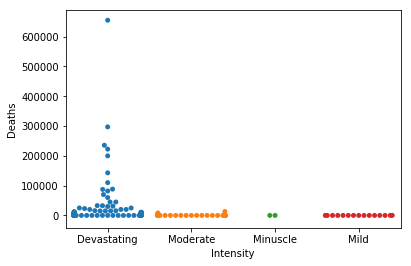

In [45]:
sns.swarmplot(x='Intensity', y= 'Deaths', data = quake_df_dens)

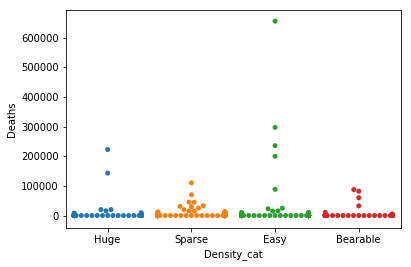

In [46]:
# looking for the effect of Intensity and Density on deaths
sns.swarmplot(x='Density_cat', y= 'Deaths', data = quake_df_dens)

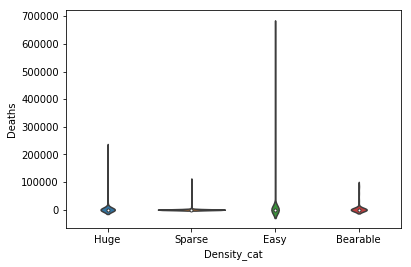

In [47]:
sns.violinplot(x='Density_cat', y= 'Deaths', data = quake_df_dens)

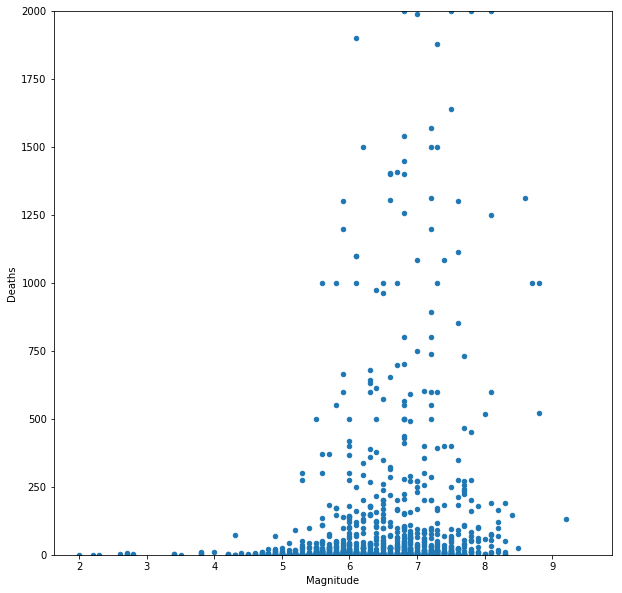

In [49]:
quake_df_dens.plot(kind="scatter",     # Create a scatterplot
              x='Magnitude',          # Put carat on the x axis
              y='Deaths',          # Put price on the y axis
              figsize=(10,10),
              ylim=(0,2000))  


In [50]:
from bokeh.io import output_file, show
plot = figure()
plot.circle(quake_df_dens['Magnitude'], quake_df['Deaths'], size =10)
output_file('magdeath.html')
show(plot)

In [52]:

plot = figure()
plot.circle(quake_df_dens['Density'], quake_df_dens['Deaths'], size =10)
output_file('magdeath1.html')
show(plot)

